# Imports

In [1]:
import json
import locale
import os
from datetime import datetime

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler

keras.saving.get_custom_objects().clear()

from stock_modules.stock_transform import (create_batch_xy,
                                           create_transformer_onehot_xy)
from stock_modules.stock_ml import (MultiSoftmaxLoss, MultiAccuracy)
from stock_modules.stock_embed import timestamps_to_marks
from stock_modules.stock_autoformer import Autoformer

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_direction_model)
from stock_modules.stock_plot import plot_mask_and_data

import matplotlib.pyplot as plt
%matplotlib widget

2023-12-19 05:13:49.835565: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 05:13:49.860422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 05:13:49.860444: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 05:13:49.860448: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 05:13:49.864864: I tensorflow/core/platform/cpu_feature_g

# Constants

In [2]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23.csv"
MODEL_SERIAL = None
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"

TEST_FRAC = 0.2
PREDICT_PRICES = False

# Data Import

In [3]:
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH,
                                  "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)

DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns

# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}

print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe columns: \n", DATAFRAME.columns)
print("Dataframe shape: ", DATAFRAME.shape)
print("Dataframe head: \n", DATAFRAME.head(2))
print(f"Index conversion: \n {IND_CONVERSION}")

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe columns: 
 Index(['REG1V.HE', 'NESTE.HE', 'ORNBV.HE', 'KNEBV.HE', 'OLVAS.HE', 'HUH1V.HE',
       'DETEC.HE', 'ORNAV.HE', 'CGCBV.HE', 'VAIAS.HE', 'ALBBV.HE', 'VALMT.HE',
       'EQV1V.HE', 'PON1V.HE'],
      dtype='object')
Dataframe shape:  (4389, 14)
Dataframe head: 
                       REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE   OLVAS.HE  \
date                                                                         
2021-10-12 07:00:00  55.950001  41.820000  35.689999  60.220001  53.099998   
2021-10-12 08:00:00  55.799999  41.720001  35.630001  60.419998  53.299999   

                      HUH1V.HE  DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE  \
date                                                                        
2021-10-12 07:00:00  38.529999      23.0  38.049999  43.139999  

# Data Treatment

In [4]:
test_begin_idx = int(DATAFRAME.shape[0] * (1 - TEST_FRAC))

if PREDICT_PRICES:
    scaler = MinMaxScaler()

    scaler.fit(DATAFRAME.iloc[:test_begin_idx, :])
    transformed_df = pd.DataFrame(scaler.transform(DATAFRAME), columns=DATAFRAME.columns, index=DATAFRAME.index)
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        if isinstance(df, pd.DataFrame):
            return pd.DataFrame(scaler.inverse_transform(df), columns=df.columns, index=df.index)
        elif isinstance(df, np.ndarray):
            return scaler.inverse_transform(df)

# If we are predicting the up/down, we create a dataframe where we subtract the previous value from the current value
else:
    # Do not diff the Time Delta column
    df = DATAFRAME.copy()
    if HAS_TIMEDELTA:
        td_col = df["Time Delta"]
        df.drop("Time Delta", axis=1, inplace=True)
    transformed_df = df.diff()
    # The first row is NaN, so lets copy the second row there
    transformed_df.iloc[0, :] = transformed_df.iloc[1, :]
    # Add back the Time Delta column
    if HAS_TIMEDELTA:
        transformed_df["Time Delta"] = td_col
        # Make Time Delta the first column
        cols = transformed_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        transformed_df = transformed_df[cols]
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        return df

print("Transformed df: \n", transformed_df.head(2))
print("Transformed df shape: ", transformed_df.shape)

Transformed df: 
                      REG1V.HE  NESTE.HE  ORNBV.HE  KNEBV.HE  OLVAS.HE  \
date                                                                    
2021-10-12 07:00:00 -0.150002 -0.099998 -0.059998  0.199997  0.200001   
2021-10-12 08:00:00 -0.150002 -0.099998 -0.059998  0.199997  0.200001   

                     HUH1V.HE  DETEC.HE  ORNAV.HE  CGCBV.HE  VAIAS.HE  \
date                                                                    
2021-10-12 07:00:00  0.030003       0.0       0.0  0.360001 -0.200001   
2021-10-12 08:00:00  0.030003       0.0       0.0  0.360001 -0.200001   

                     ALBBV.HE  VALMT.HE  EQV1V.HE  PON1V.HE  
date                                                         
2021-10-12 07:00:00  0.099998  0.139999       0.1  0.049999  
2021-10-12 08:00:00  0.099998  0.139999       0.1  0.049999  
Transformed df shape:  (4389, 14)


# Model Optimization

2023-12-19 05:13:53.327773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 05:13:53.345382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 05:13:53.345435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 05:13:53.347058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 05:13:53.347107: I tensorflow/compile

Epoch 1/50


2023-12-19 05:14:08.149010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 05:14:08.158098: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 05:14:08.477306: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 05:14:09.957582: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2704c9b8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 05:14:09.957616: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-12-19 05:14:09.961041: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-19 05:14:10.006715: I ./tensorflow/compiler/jit/device_comp

81/81 [==============================] - 32s 160ms/step - loss: 1.1849 - multi_accuracy: 0.3412 - val_loss: 1.1852 - val_multi_accuracy: 0.3318
Epoch 2/50
81/81 [==============================] - 9s 108ms/step - loss: 1.1849 - multi_accuracy: 0.3358 - val_loss: 1.1852 - val_multi_accuracy: 0.3317
Epoch 3/50
81/81 [==============================] - 9s 112ms/step - loss: 1.1849 - multi_accuracy: 0.3344 - val_loss: 1.1852 - val_multi_accuracy: 0.3317
Epoch 4/50
81/81 [==============================] - 9s 115ms/step - loss: 1.1849 - multi_accuracy: 0.3336 - val_loss: 1.1852 - val_multi_accuracy: 0.3317
Epoch 5/50
81/81 [==============================] - 9s 108ms/step - loss: 1.1849 - multi_accuracy: 0.3332 - val_loss: 1.1852 - val_multi_accuracy: 0.3317
Epoch 6/50
27/27 [==============================] - 1s 49ms/step - loss: 1.1943 - multi_accuracy: 0.3300


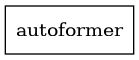

In [5]:
if not os.path.exists("./models/"):
    os.makedirs("./models/")

CLASS_FIRST = True

if MODEL_SERIAL is None:
    counter = 0
    RESUME = 0

    for memory_length in [100]:
        if PREDICT_PRICES:
            OUTPUT_SCALE = (0,1)
            x, y = create_batch_xy(
                        memory_length,
                        transformed_np_arr,
                        overlap=True,
                        y_updown=False,
                        diff_data=True,
                        output_scale=OUTPUT_SCALE)
        else:
            x, x_ts, y = create_transformer_onehot_xy(
                                memory_length,
                                transformed_np_arr,
                                DATAFRAME.to_numpy(),
                                DATAFRAME.index.to_numpy(),
                                0.002)

        y_ts = timestamps_to_marks(
            DATAFRAME.index.to_numpy()[memory_length:], 1)
        split_idx = int(x.shape[0] * (1 - TEST_FRAC))

        x_train = x[:split_idx,:,:]
        x_ts_train = x_ts[:split_idx,:,:]
        y_train = y[:split_idx,:,:]
        y_ts_train = y_ts[:split_idx,:,:]

        x_test = x[split_idx:,:,:]
        x_ts_test = x_ts[split_idx:,:,:]
        y_test = y[split_idx:,:,:]
        y_ts_test = y_ts[split_idx:,:,:]

        if CLASS_FIRST:
            y_train = tf.transpose(y_train, (0,2,1))
            y_test = tf.transpose(y_test, (0,2,1))

        for head_size in [8]:
            for num_heads in [2]:
                for ff_dim in [16]:
                    for num_autoformer_blocks in [2]:
                        for random_seed in [0]:
                            if counter < RESUME:
                                counter = counter + 1
                                continue

                            keras.utils.set_random_seed(random_seed)
                            
                            serial = "autoformer_model_" \
                                + datetime.now().strftime("%Y%m%d%H%M%S")
                            model_dict = {
                                "serial": serial,
                                "d_model": head_size,
                                "dropout_rate": 0.01,
                                "d_ff": ff_dim,
                                "d_out": 14,
                                "N": num_autoformer_blocks,
                                "M": num_autoformer_blocks,
                                "k": 2,
                                "h": num_heads,
                                "O": 1,
                                "tau": 10,
                                "seed": random_seed
                            }
                            model = Autoformer(model_dict)

                            model.compile(optimizer=keras.optimizers.Adam(),
                                        loss=MultiSoftmaxLoss(),
                                        metrics=[MultiAccuracy()])

                            model.fit(x =
                                    (x_train,x_ts_train,y_ts_train),
                                    y = y_train,
                                    batch_size=32,
                                    epochs=50,
                                    validation_split=0.25,
                                    callbacks=[
                                        keras.callbacks.EarlyStopping(
                                            patience=5,
                                            restore_best_weights=True
                                        )
                                    ])
                            
                            model.save("./models/"+serial+".keras")

                            model_dict.update(model.evaluate(
                                        x =(x_test,
                                            x_ts_test,
                                            y_ts_test),
                                        y = y_test,
                                        batch_size=32,
                                        workers=4,
                                        use_multiprocessing=True,
                                        return_dict=True
                                    )
                                )
                            
                            if os.path.exists("./autoformer_results.json"):
                                with open("./autoformer_results.json", "r",
                                        encoding=ENCODING) as json_file:
                                    model_list = json.load(json_file)
                                model_list.append(model_dict)
                            else:
                                model_list = [model_dict]

                            with open("./autoformer_results.json", "w",
                                    encoding=ENCODING) as json_file:
                                json.dump(model_list, json_file)

                            keras.backend.clear_session()

    if os.path.exists("./autoformer_results.json"):
        with open("./autoformer_results.json", "r",
                  encoding=ENCODING) as json_file:
            model_list = json.load(json_file)
    else:
        model_list = [{}]
    
    model_df = pd.DataFrame.from_dict(model_list)
    model_df.to_excel("./autoformer_results.xlsx")
else:
    model = keras.models.load_model("./models/" + MODEL_SERIAL + ".keras")
    memory_length = model.input_shape[0][1]-1

    if PREDICT_PRICES:
        OUTPUT_SCALE = (0,1)
        x, y = create_batch_xy(
                    memory_length,
                    transformed_np_arr,
                    overlap=True,
                    y_updown=False,
                    diff_data=True,
                    output_scale=OUTPUT_SCALE)
    else:
        x, x_ts, y = create_transformer_onehot_xy(
                            memory_length,
                            transformed_np_arr,
                            DATAFRAME.to_numpy(),
                            DATAFRAME.index.to_numpy(),
                            0.002)

    y_ts = timestamps_to_marks(
            DATAFRAME.index.to_numpy()[memory_length:], 1)
    split_idx = int(x.shape[0] * (1 - TEST_FRAC))

    x_train = x[:split_idx,:,:]
    x_ts_train = x_ts[:split_idx,:,:]
    y_train = y[:split_idx,:,:]
    y_ts_train = y_ts[:split_idx,:,:]

    x_test = x[split_idx:,:,:]
    x_ts_test = x_ts[split_idx:,:,:]
    y_test = y[split_idx:,:,:]
    y_ts_test = y_ts[split_idx:,:,:]

    if CLASS_FIRST:
        y_train = tf.transpose(y_train, (0,2,1))
        y_test = tf.transpose(y_test, (0,2,1))
plot_model(
        model,
        to_file="./figures/autoformer_model_plot.png",
        show_shapes=True,
        show_layer_names = True
    )

# Benchmark

## Accuracy

In [6]:
y_pred = model([x_test, x_ts_test, y_ts_test], training=False)
print("Y_pred: \n", y_pred)
print("Y_test: \n", y_test)

for stock_idx in range(y_pred.shape[2] if CLASS_FIRST else y_pred.shape[1]):
    if CLASS_FIRST:
        direction_preds = y_pred[:,:,stock_idx]
        direction_true = y_test[:,:,stock_idx]
    else:
        direction_preds = y_pred[:,stock_idx,:]
        direction_true = y_test[:,stock_idx,:]

    direction_preds = np.argmax(direction_preds, axis=1)
    direction_true = np.argmax(direction_true, axis=1)

    accuracy = \
        np.sum(direction_preds == direction_true) / direction_preds.shape[0]
    print(f"""
            Up/Down/Flat accuracy for stock {IND_CONVERSION[stock_idx]}:
            {accuracy}
            """
        )

Y_pred: 
 tf.Tensor(
[[[0.5120113  0.6083514  0.58496666 ... 0.8367532  0.5475638  0.9529203 ]
  [0.8441639  1.003002   0.9644469  ... 1.3795727  0.90278006 1.5710999 ]
  [1.391791   1.6536707  1.5901042  ... 2.2745311  1.4884326  2.590306  ]]

 [[0.81408054 0.4865843  0.73615307 ... 0.881686   0.6746426  0.9449104 ]
  [1.3421919  0.8022419  1.2137111  ... 1.4536545  1.1122975  1.5578938 ]
  [2.2129002  1.3226733  2.0010715  ... 2.396671   1.8338686  2.5685327 ]]

 [[0.6844367  0.57982534 0.75288445 ... 0.64716476 0.7181045  0.5755902 ]
  [1.1284453  0.9559703  1.2412968  ... 1.0669943  1.1839541  0.9489878 ]
  [1.8604918  1.5761285  2.0465522  ... 1.7591761  1.9520102  1.5646162 ]]

 ...

 [[0.56326604 0.54794997 0.7206899  ... 0.45051497 0.66653925 0.53728354]
  [0.92866856 0.9034168  1.1882168  ... 0.7427736  1.0989374  0.8858308 ]
  [1.5311155  1.4894826  1.9590381  ... 1.2246265  1.8118415  1.460488  ]]

 [[0.3924608  0.55354    0.62556815 ... 0.56081027 0.58393997 0.49263665]
  [

## Profitability

In [7]:
# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 3rd stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test,
                                                     optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
print(transformed_np_arr_test[0:2,:])
prediction_trading_mask = \
    strategy_mask_from_direction_model(transformed_np_arr_test,
                                       memory_length, model,
                                       "autoformer",
                                       df.to_numpy()[-test_sz:,:],
                                       df.index.to_numpy()[-test_sz:]
                                       )

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 3rd stock: \n {prediction_trading_mask[:,2]}")
if HAS_TIMEDELTA:
    profit_pred_model = \
        calculate_profit_on_invest_strategy(np_arr_test[:,1:],
                                            prediction_trading_mask)
else:
    profit_pred_model = \
        calculate_profit_on_invest_strategy(np_arr_test,
                                            prediction_trading_mask)

print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(
    f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 3rd stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

## Plotting

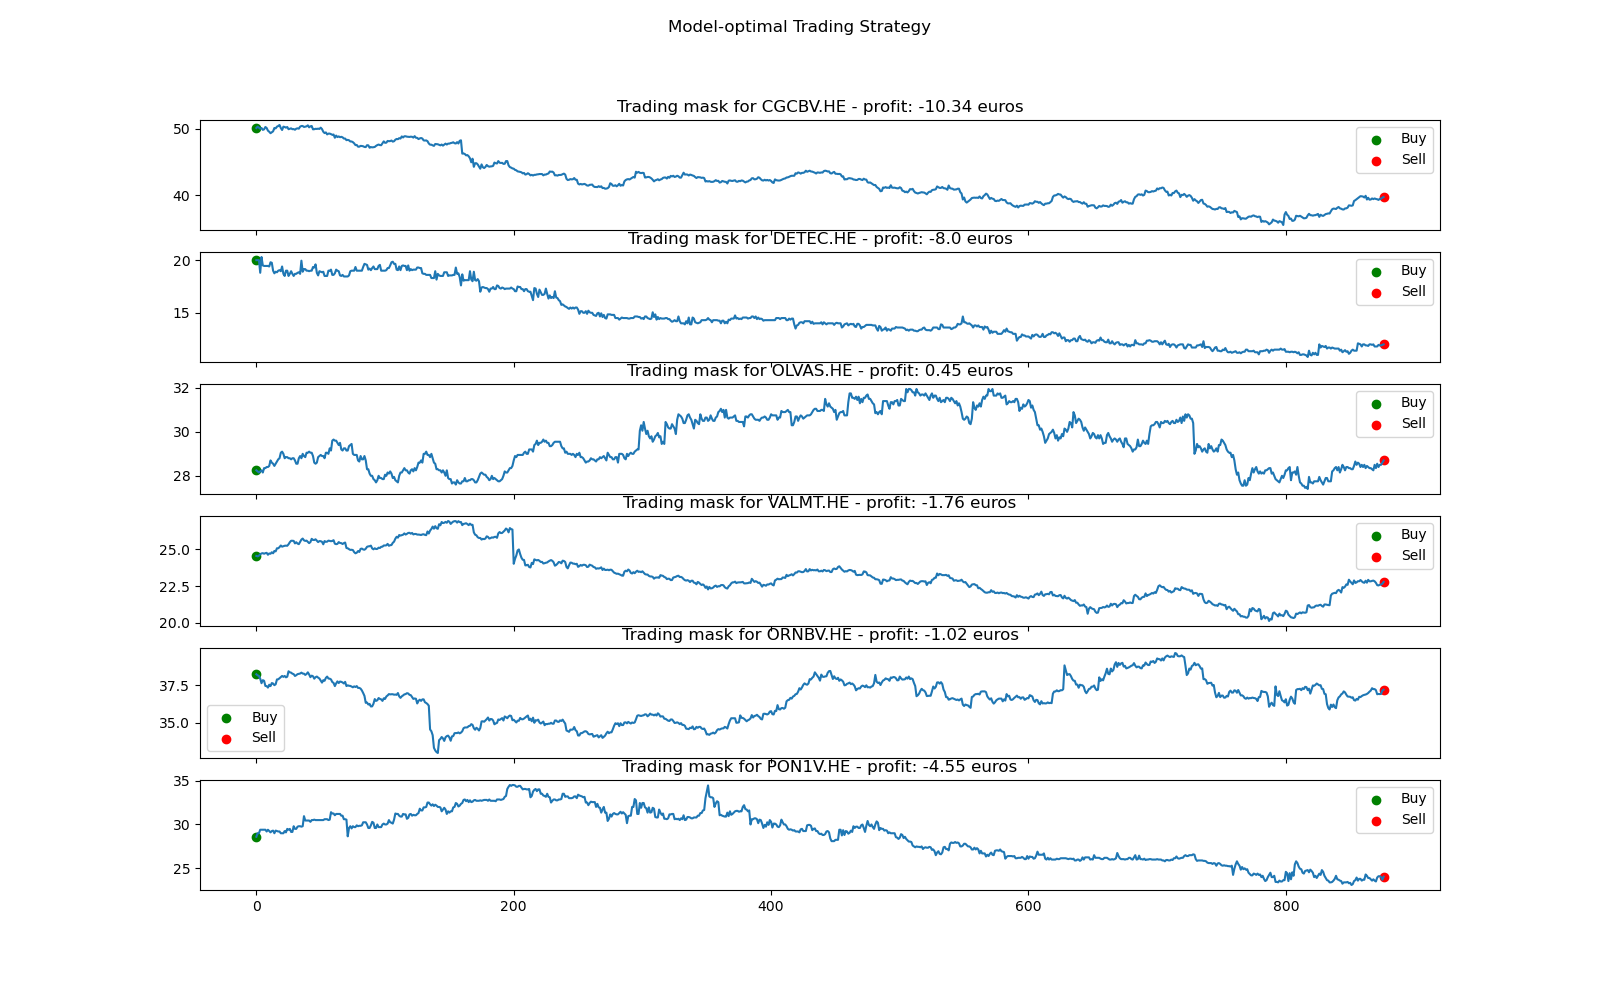

(<Figure size 1600x1000 with 6 Axes>,
 array([<Axes: title={'center': 'Trading mask for CGCBV.HE - profit: -10.34 euros'}>,
        <Axes: title={'center': 'Trading mask for DETEC.HE - profit: -8.0 euros'}>,
        <Axes: title={'center': 'Trading mask for OLVAS.HE - profit: 0.45 euros'}>,
        <Axes: title={'center': 'Trading mask for VALMT.HE - profit: -1.76 euros'}>,
        <Axes: title={'center': 'Trading mask for ORNBV.HE - profit: -1.02 euros'}>,
        <Axes: title={'center': 'Trading mask for PON1V.HE - profit: -4.55 euros'}>],
       dtype=object))

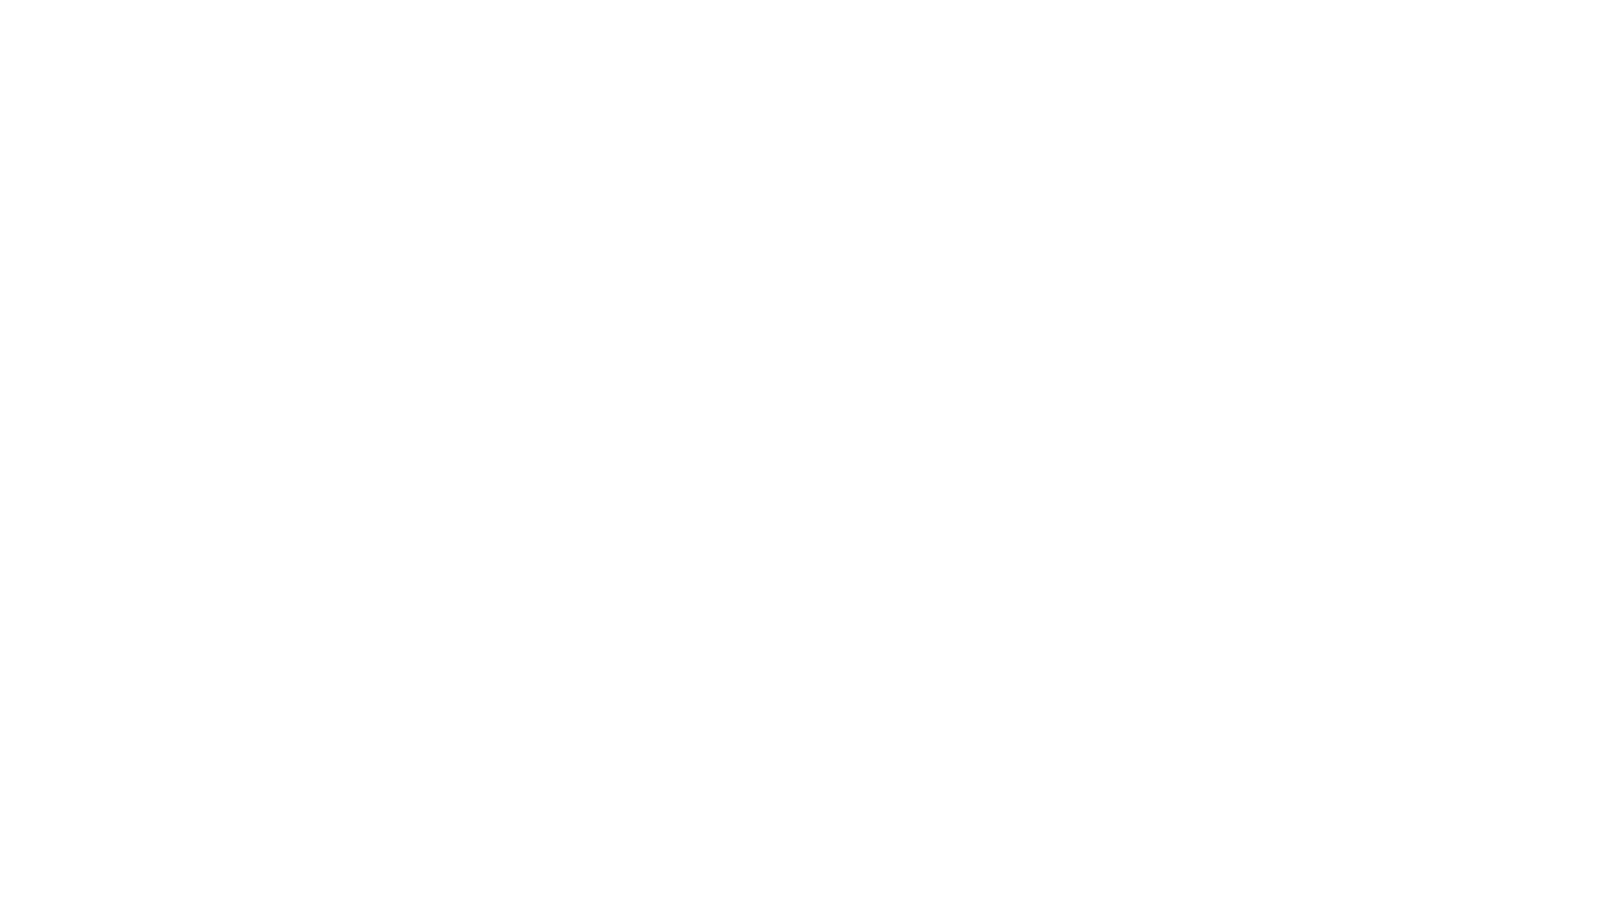

In [8]:
stock_indices = np.random.choice(np.arange(len(IND_CONVERSION)), 6,
                                 replace=False)
part_mask = prediction_trading_mask[:,stock_indices]

if HAS_TIMEDELTA:
    part_price = np_arr_test[:,1:][:,stock_indices]
else:
    part_price = np_arr_test[:,stock_indices]

ind_conversion = {si : IND_CONVERSION[i] for si, i in enumerate(stock_indices)}
plt.figure(figsize=(16,9))
plot_mask_and_data(part_mask, part_price, ind_conversion)